# Importando pacotes e dataset

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Análise de Série Temporal

Uma série temporal representa uma sequência de observações de uma variável específica ao longo do tempo. Na análise de séries temporais, um dos principais objetivos é a previsão dos valores futuros dessa variável. Essa capacidade de previsão é viável devido à persistência parcial dos valores da variável ao longo do tempo - o valor em um determinado período está relacionado aos valores que a variável assumiu em períodos anteriores. Portanto, é possível estabelecer uma correlação entre a variável em estudo e seus valores passados.

Antes de iniciar a análise preditiva propriamente dita, irei realizar uma etapa de análise preliminar dos dados. Esta etapa engloba procedimentos de limpeza inicial e a primeira visualização dos dados, que são cruciais para a compreensão e preparação adequada antes de qualquer previsão ou modelagem.

In [106]:
# lendo a base
df = pd.read_csv("/content/drive/MyDrive/bcdata.sgs.21082.csv", sep=';', decimal=',')


In [107]:
df.head()

,data,valor
0,01/03/2011,3.17
1,01/04/2011,3.24
2,01/05/2011,3.37
3,01/06/2011,3.32
4,01/07/2011,3.42


In [108]:
df.tail()

,data,valor
144,01/03/2023,3.29
145,01/04/2023,3.48
146,01/05/2023,3.58
147,01/06/2023,3.56
148,01/07/2023,3.60


In [109]:
df.shape

(149, 2)

A série é composta de 149 linhas e 2 colunas, uma referente a data e outra ao valor em percentual. Os dados são mensais e se iniciam em primeiro de março de 2011, finalizando em primeiro de julho de 2023.

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    149 non-null    object 
 1   valor   149 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


Diversos algoritmos utilizados em análise de dados na previsão de séries temporais podem ter problemas com dados nulos. Por isso, precisaremos lidar com eles antes de iniciar o trabalho. Além disso, confome os dados de `info` acima, temos que converter a coluna de data para datetime.

In [ ]:
df.isnull().sum()


data     0
valor    0
dtype: int64

In [111]:
#corrigindo os valores para datetime
df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
#convertendo para index
df = df.set_index('data')


In [112]:
df.head()

,valor
data,
2011-03-01,3.17
2011-04-01,3.24
2011-05-01,3.37
2011-06-01,3.32
2011-07-01,3.42


O objetivo deste estudo é realizar previsões de valores para datas futuras. Por isso, vamos entender um pouco mais sobre nossos dados:

In [113]:
df. describe()

,valor
count,149.000000
mean,3.143087
std,0.453813
min,2.120000
25%,2.890000
50%,3.120000
75%,3.540000
max,4.040000


A média de inadimplência, em percentual, é de 3.14%, com mediana de 3.12. O valor mínimo é de 2.12% e o máximo é de 4%.

In [114]:
df['ano'] = pd.DatetimeIndex(df.index).year
df['mes'] = pd.DatetimeIndex(df.index).month

In [115]:
df.tail()

,valor,ano,mes
data,,,
2023-03-01,3.29,2023,3
2023-04-01,3.48,2023,4
2023-05-01,3.58,2023,5
2023-06-01,3.56,2023,6
2023-07-01,3.60,2023,7


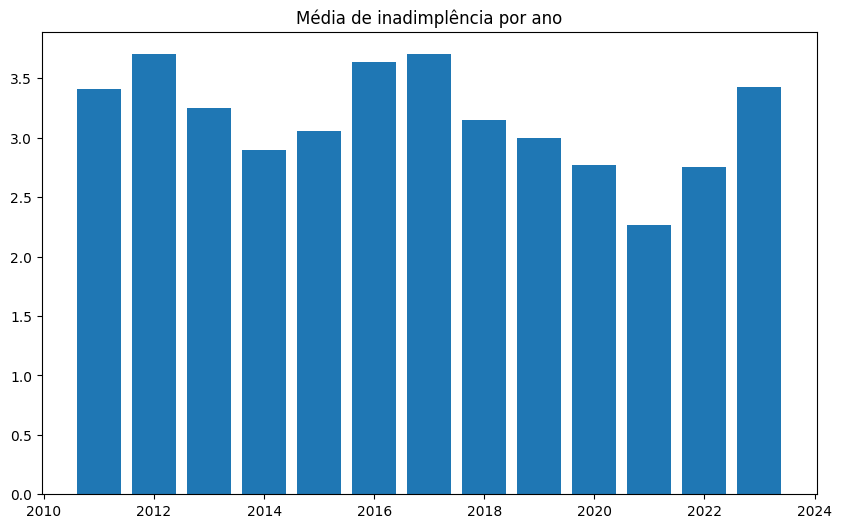

In [116]:
cred_ano = df.groupby(['ano']).mean()
plt.figure(figsize = (10,6))
#plt.rcParam['fontsize'] = '14'
plt.bar(cred_ano.index, cred_ano['valor'].values)
plt.title('Média de inadimplência por ano')
plt.show()

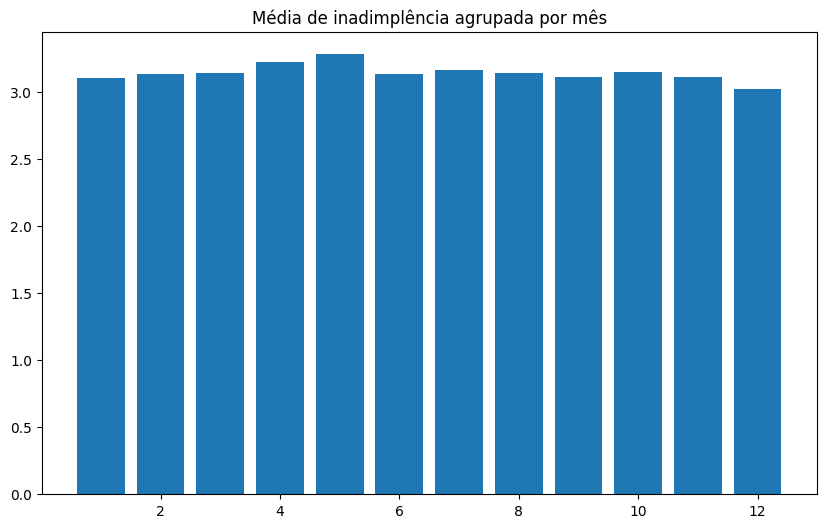

In [117]:
cred_mes = df.groupby(['mes']).mean()
plt.figure(figsize = (10,6))
#plt.rcParam['fontsize'] = '14'
plt.bar(cred_mes.index, cred_mes['valor'].values)
plt.title('Média de inadimplência agrupada por mês')
plt.show()

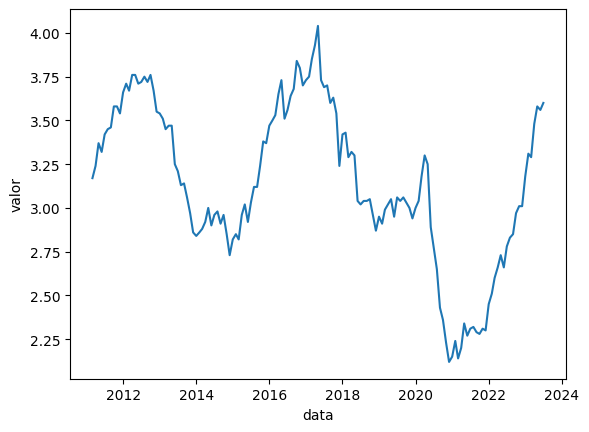

In [119]:
sns.lineplot(data=df, x=df.index, y = df.valor)
plt.show()

Algumas observações:

- A série parece se comportar de forma cíclica, repetindo um padrão em um intervalo de anos. Esse padrão pode estar relacionado com indicadores de economicos e com períodos de recessão e crescimento.
- Porém devido ao choque da COVID-2019, a série muda de comportamento atigindo valores mínimos. Durante esse período, por causa das medidas  de isolamento social, o governo adotou medidas econômicas que podem ter influenciado esse comportamento.
- Porém, em 2022 a série volta a crescer.


In [136]:
#média móvel
df['media_movel'] = df['valor'].rolling(20).mean()

In [126]:
df.tail()

,valor,ano,mes,media_movel
data,,,,
2023-03-01,3.29,2023,3,2.556667
2023-04-01,3.48,2023,4,2.594000
2023-05-01,3.58,2023,5,2.639000
2023-06-01,3.56,2023,6,2.687000
2023-07-01,3.60,2023,7,2.735333


O valor 30 para calcular a média móvel dos últimos 20 meses, já que a menor divisão de dados é meses

<Axes: xlabel='Data', ylabel='Inadimplência'>

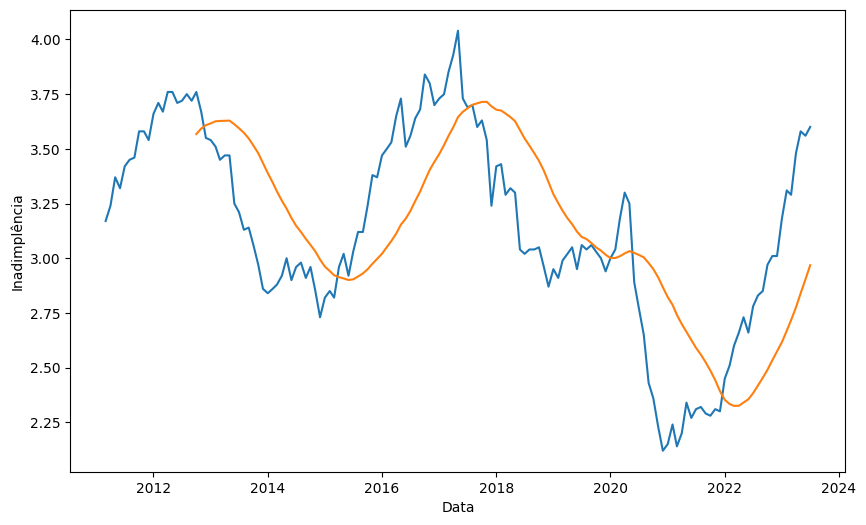

In [137]:
#ajuste da figura
plt.figure(figsize = (10,6))

#série temporal
sns.lineplot(x= df.index, y ='valor', data = df)
plt.xlabel('Data')
plt.ylabel('Inadimplência')

#gera o gráfico da média móvel

sns.lineplot(x= df.index, y =  'media_movel', data = df)
#plt.legend(labels['Série Temporal', 'Média Móvel'])

A ideia desse tipo de gráfico é permitir a análise da tendência geral dos dados sem nos prender às vvariaçõe bruscas e pontuais que podem não se manter no decorrer do tempo.

# Decomposição da série temporal

A decomposição de uma série temporal em seus componentes consiste em identificar três elementos distintos: um componente de tendência, um componente de sazonalidade e, quando aplicável, um componente de irregularidade. A sazonalidade refere-se a variações que ocorrem periodicamente na série temporal. Essas variações repetem-se em intervalos regulares ao longo da série. O componente de tendência indica se a série está apresentando uma tendência de crescimento, decaimento ou se mantém estável ao longo do tempo. O componente de irregularidade, por sua vez, representa a variabilidade que permanece na série após a separação da tendência e da sazonalidade, ou seja, as flutuações que não podem ser explicadas pelo modelo.



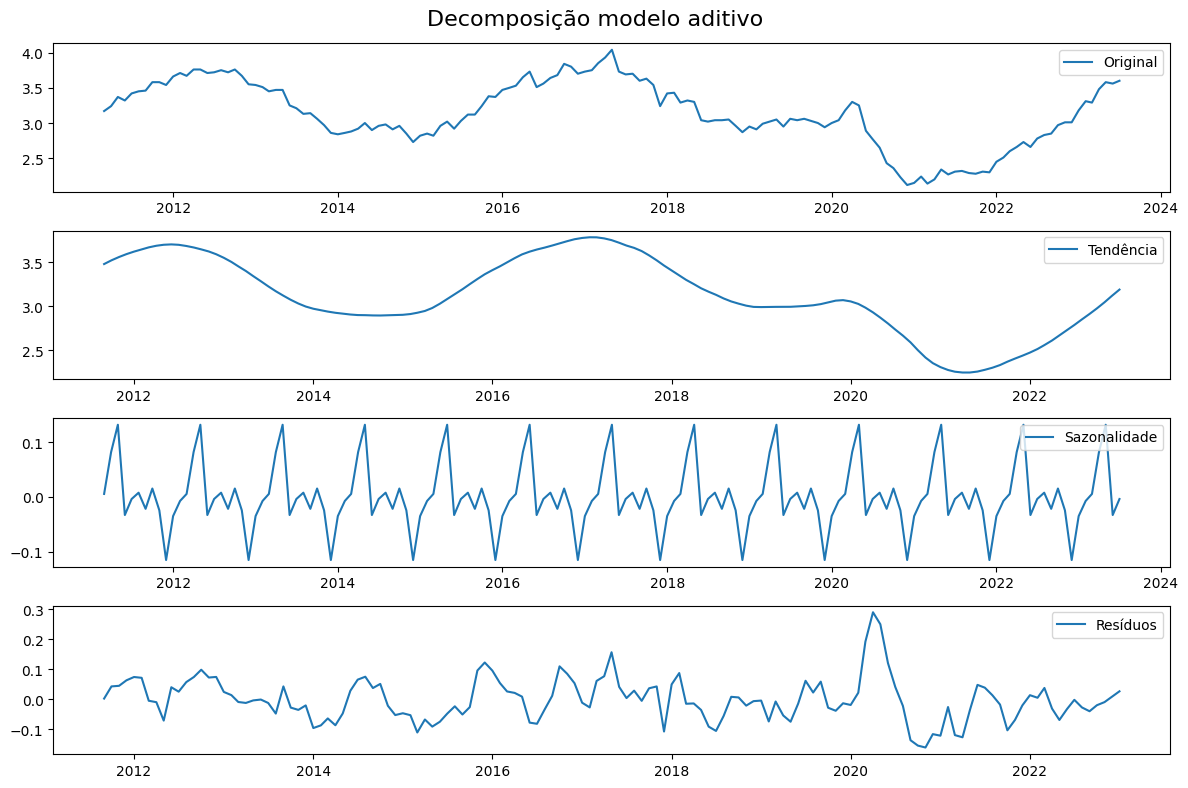

In [139]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

decomposition = sm.tsa.seasonal_decompose(df['valor'], model='additive')

tendencia = decomposition.trend
sazonalidade = decomposition.seasonal
residuo = decomposition.resid

plt.figure(figsize=(12, 8))
plt.suptitle('Decomposição modelo aditivo', fontsize=16)
plt.subplot(411)
plt.plot(df['valor'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Tendência')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(sazonalidade, label='Sazonalidade')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuo, label='Resíduos')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


O gráfico acima apresenta a série temporal original no topo, a estimativa do componente de tendência no segundo gráfico, a estimativa do componente de sazonalidade no terceiro painel e a estimativa dos resíduos. É evidente a presença do componente de sazonalidade, que inicia cada ano em um ponto baixo e gradualmente cresce até atingir o pico por volta do meio do ano, seguido de uma queda. Esse padrão se repete a cada ano na série. Os resíduos variam em torno de zero.

Interessante é o comportamento do componente de tendência, que parece seguir um padrão cíclico de crescimento e decaimento. Este padrão parece acompanhar os ciclos econômicos. A tendência muda de comportamento em 2020, com o início da pandemia de COVID-19, e parece indicar um retorno ao padrão pré-pandemia nos últimos meses.

# Estacionariedade

A estacionariedade é um conceito fundamental na análise de séries temporais. Essencialmente, refere-se ao fato de que as propriedades estatísticas de uma série temporal (ou o processo que as gera) permanecem constantes ao longo do tempo. Uma série temporal estacionária é de suma importância, pois muitos modelos de previsão partem do pressuposto de que a série é estacionária.

Para verificar de forma robusta se uma série é estacionária, utilizamos um teste estatístico conhecido como Teste Aumentado de Dickey-Fuller, também chamado de teste de raiz unitária. A intuição por trás do teste de raiz unitária é determinar quão fortemente uma série temporal é influenciada por sua tendência. O teste ADF utiliza um modelo autorregressivo e avalia critérios de informação em diferentes valores de defasagem.

A hipótese nula subjacente a esse teste é que a série possui uma raiz unitária, o que significa que ela não é estacionária. Por outro lado, a hipótese alternativa (a que desejamos apoiar ao rejeitar a hipótese nula) sugere que a série é estacionária.

Em termos mais específicos:

Hipótese Nula (HO): Se o teste não rejeita a hipótese nula, isso sugere que a série possui uma raiz unitária, indicando não estacionariedade.
Hipótese Alternativa (H1): Se a hipótese nula é rejeitada, isso sugere que a série temporal não possui raiz unitária, o que significa que ela é estacionária.
A interpretação dos resultados do teste é baseada no valor p. Um valor p abaixo de um determinado limiar, como 5% ou 1%, leva à rejeição da hipótese nula (indicando estacionariedade). Caso contrário, não temos evidências suficientes para rejeitar a hipótese nula, sugerindo não estacionariedade.

É importante observar que a diferenciação de uma série temporal pode eliminar apenas uma raiz unitária de cada vez. Portanto, um procedimento comum é realizar testes em uma série diferenciada uma ou mais vezes. O processo começa aplicando o teste à série original em seu nível. Se a hipótese nula de raiz unitária não for rejeitada, então aplicamos o teste à primeira diferença da série. Esse processo continua até que o teste aponte consistentemente na direção da hipótese nula, indicando o número de raízes unitárias presentes na série.

In [140]:
from statsmodels.tsa.stattools import adfuller

In [141]:
adfTest = adfuller(df['valor'], autolag='AIC',)

In [142]:
adfTest

(-3.5911088549368384,
 0.005933300143819092,
 12,
 136,
 {'1%': -3.4793722137854926,
  '5%': -2.8830370378332995,
  '10%': -2.578233635380623},
 -287.0454385287293)

In [143]:
stats = pd.Series(adfTest[0:4], index=['Test Statistic', 'p-value', '#lags used', 'number of observations used'])

In [144]:
stats

Test Statistic                  -3.591109
p-value                          0.005933
#lags used                      12.000000
number of observations used    136.000000
dtype: float64

In [145]:
for key, values in adfTest[4].items():
  print( 'criticality', key,  ':', values)

criticality 1% : -3.4793722137854926
criticality 5% : -2.8830370378332995
criticality 10% : -2.578233635380623


O resultado do teste de ADF é a estatística ADF, que é de -3.591109. Compara-se esse valor com os valores críticos em diferentes níveis de significância (1%, 5% e 10%) para determinar se a série é estacionária ou não.

Os valores críticos representam os limites além dos quais se rejeita a hipótese nula de raiz unitária. Se a estatística ADF for menor (mais negativa) do que os valores críticos em um determinado nível de significância, rejeita-se a hipótese nula e conclui-se que a série é estacionária.

Neste caso, a estatística ADF de -3.591109 é menor do que os valores críticos para os níveis de significância de 1%, 5% e 10%. Portanto, com base nos resultados, pode-se concluir que a série é estacionária, uma vez que a estatística ADF cai abaixo dos valores críticos em todos os níveis de significância.

O teste ADF apresenta baixo poder estatístico quando há quebras estruturais na série. Os testes de Dickey-Fuller tendem a viés em direção à não rejeição da hipótese nula na presença de quebras estruturais, como ocorreu com a pandemia de COVID-19. Em outras palavras, as quebras estruturais representam uma fonte adicional de erro na análise.

Uma maneira de lidar com essa quebra a segmentar os dados. Em vez de aplicar o teste ADF à série temporal como um todo, segmenta-se os dados em períodos distintos e aplica-se o teste separadamente a cada segmento. Isso pode ajudar a identificar onde as quebras ocorreram e se a estacionariedade se mantém em cada segmento. Isso pode ser feita em uma etapa posterior do projeto.


# Modelo

## ARIMA e SARIMA

### Escolha dos parâmetros

Os modelos da classe ARIMA (Autoregressive Integrated Moving Average) incorporam explicitamente os componentes necessários para modelar a irregularidade de uma série temporal. No entanto, eles requerem que a série seja estacionária. Se começarmos com uma série que não é estacionária, é necessário diferenciá-la repetidamente até que ela se torne adequada para análise. Ao realizar a diferenciação da série um total de "d" vezes até alcançarmos a estacionariedade, obtemos um modelo ARIMA(p, d, q), onde "d" representa o número de diferenciações realizadas. Se não for necessário diferenciar a série, o valor de "d" é 0. Isso significa que podemos utilizar um modelo ARIMA(p, 0, q) para a série temporal.

O próximo passo consiste em determinar os valores apropriados para os parâmetros "p" e "q" no modelo ARIMA. Para fazer isso, analisamos o correlograma e o correlograma parcial da série estacionária:



In [146]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

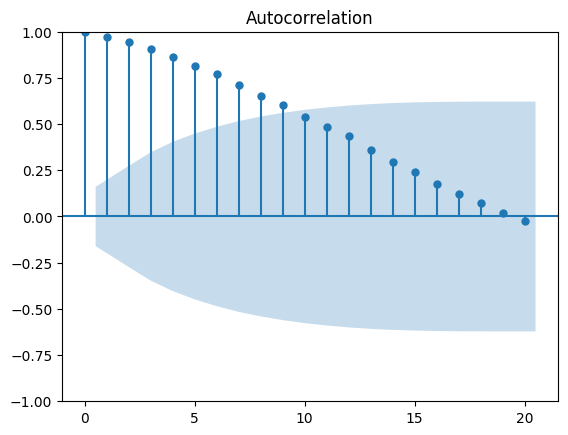

In [147]:
plot_acf(df['valor'], lags=20);

Acima, temos o gráfico do correlograma para as defasagens de 1 a 20 da série em nível representando o valor em percentual da inadimplência da carteira de crédito. Podemos observar no correlograma das defasagens que, até cerca da defasagem 10, as autocorrelações ainda estão fora do intervalo de confiança, mas todas as defasagens posteriores a essa não ultrapassam o intervalo.

Realizando o mesmo procedimento para o correlograma parcial das autocorrelações, temos:





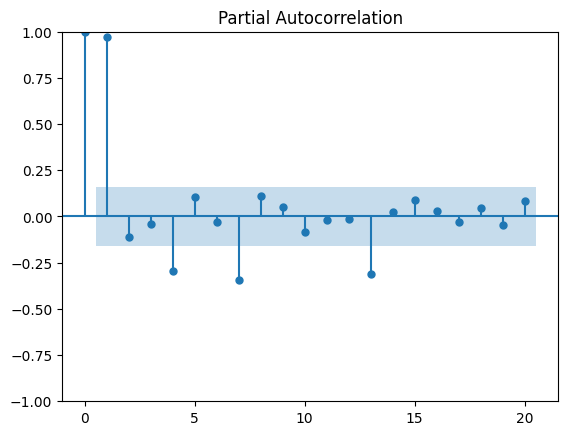

In [ ]:
plot_pacf(df['valor'], lags=20);

O correlograma parcial revela que a autocorrelação nas defasagens 1, 2, 5, 8 e 14 excede o intervalo de confiança. A escolha adequada do modelo também passa pela seleção do número de defasagens. Se o modelo estimado tiver um número reduzido de defasagens em relação ao processo gerador de dados, pode haver autocorrelação residual, o que distorcerá os resultados. Por outro lado, ao adicionar defasagens adicionais, perdemos graus de liberdade devido ao aumento no número de parâmetros em simultâneo com a diminuição do número de observações disponíveis.

Considerando a perda de graus de liberdade, um número excessivo de defasagens diminui o poder dos testes estatísticos. É possível realizar vários testes para determinar quantas defasagens devem ser incluídas no modelo, mas é preferível adotar uma abordagem parcimoniosa. Assumimos que o modelo com menos parâmetros é o melhor. Neste caso, um modelo ARIMA(1,0,1) parece apropriado.

Além disso, também vamos utilizar a função auto.arima para auxiliar na escolha do modelo adequado. Essa função nos ajudará a selecionar um modelo com base em critérios estatísticos, levando em consideração a complexidade e o ajuste aos dados observados.

In [171]:

from pmdarima import auto_arima

arima = auto_arima(df['valor'], seasonal=True, m=12)

# Exiba os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:", arima.order)




Melhores parâmetros encontrados: (1, 1, 1)


O AutoArima selecionou como melhor modelo os parâmetros (1,1,1),enquanto minha escolha foi o (1,0,1). Irei utilizar os dois modelos e comparar suas métricas.

Primeiro, dividirei o dataset em test e treino. Os 80% primeiros dados serão de treino e 20% serão de teste.

In [151]:
train = df[:round(len(df)*80/100)]
test = df[round(len(df)*80/100):]


In [153]:
train.head()

,valor,ano,mes,media_movel
data,,,,
2011-03-01,3.17,2011,3,NaN
2011-04-01,3.24,2011,4,NaN
2011-05-01,3.37,2011,5,NaN
2011-06-01,3.32,2011,6,NaN
2011-07-01,3.42,2011,7,NaN


In [152]:
train.tail()

,valor,ano,mes,media_movel
data,,,,
2020-09-01,2.43,2020,9,2.9780
2020-10-01,2.36,2020,10,2.9505
2020-11-01,2.23,2020,11,2.9125
2020-12-01,2.12,2020,12,2.8675
2021-01-01,2.15,2021,1,2.8225


In [154]:
test.head()

,valor,ano,mes,media_movel
data,,,,
2021-02-01,2.24,2021,2,2.787
2021-03-01,2.14,2021,3,2.741
2021-04-01,2.20,2021,4,2.699
2021-05-01,2.34,2021,5,2.663
2021-06-01,2.27,2021,6,2.625


In [155]:
test.tail()

,valor,ano,mes,media_movel
data,,,,
2023-03-01,3.29,2023,3,2.7170
2023-04-01,3.48,2023,4,2.7750
2023-05-01,3.58,2023,5,2.8395
2023-06-01,3.56,2023,6,2.9035
2023-07-01,3.60,2023,7,2.9680


In [157]:
from statsmodels.tsa.arima.model import ARIMA
#ajustando o modelo ARIMA
model_arima = ARIMA(train['valor'], order=(1, 0, 1))
model_arima_fit = model_arima.fit()
prediction_arima = model_arima_fit.predict(start=test.index[0], end=test.index[-1])

In [158]:
df['arimaPred'] = prediction_arima
df.tail(12)

,valor,ano,mes,media_movel,arimaPred
data,,,,,
2022-08-01,2.83,2022,8,2.4185,2.500424
2022-09-01,2.85,2022,9,2.4535,2.514239
2022-10-01,2.97,2022,10,2.4900,2.527687
2022-11-01,3.01,2022,11,2.5335,2.540778
2022-12-01,3.01,2022,12,2.5740,2.553523
2023-01-01,3.18,2023,1,2.6160,2.565930
2023-02-01,3.31,2023,2,2.6680,2.578008
2023-03-01,3.29,2023,3,2.7170,2.589765
2023-04-01,3.48,2023,4,2.7750,2.601212


<Axes: xlabel='data', ylabel='valor'>

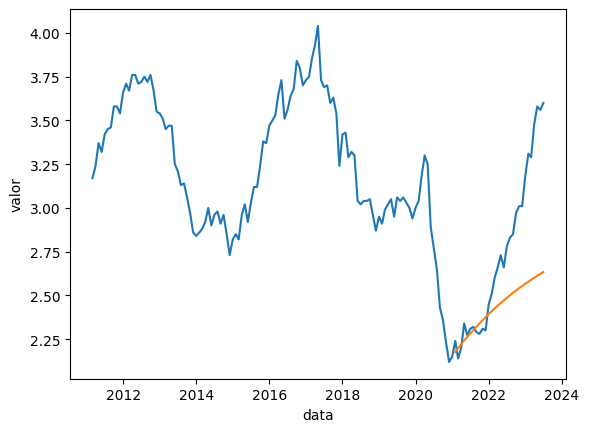

In [161]:
sns.lineplot(data = df, x= df.index, y = 'valor')
sns.lineplot(data = df, x= df.index, y = 'arimaPred')


O modelo parece se ajustar bem aos dados de pandemia mais sobrestimar como a série se comporta pós pandemia.

In [ ]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['valor'],  prediction_arima))

0.600166526891551

 O RMSE calculado é aproximadamente 0.6002. Isso significa que, em média, as previsões do modelo ARIMA têm um erro de 0.6002 unidades em relação aos valores reais de teste. Um desempenho razoável. Vamos testar com os parâmetros escolhidos pela função AutoArima:

In [162]:
model_auto_arima = ARIMA(train['valor'], order=(1, 1, 1))
model_auto_arima_fit = model_auto_arima.fit()
prediction_auto_arima = model_auto_arima_fit.predict(start=test.index[0], end=test.index[-1])

In [163]:
df['autoArimaPred'] = prediction_auto_arima
df.tail()

,valor,ano,mes,media_movel,arimaPred,autoArimaPred
data,,,,,,
2023-03-01,3.29,2023,3,2.7170,2.589765,2.155377
2023-04-01,3.48,2023,4,2.7750,2.601212,2.155377
2023-05-01,3.58,2023,5,2.8395,2.612354,2.155377
2023-06-01,3.56,2023,6,2.9035,2.623202,2.155377
2023-07-01,3.60,2023,7,2.9680,2.633762,2.155377


<Axes: xlabel='data', ylabel='valor'>

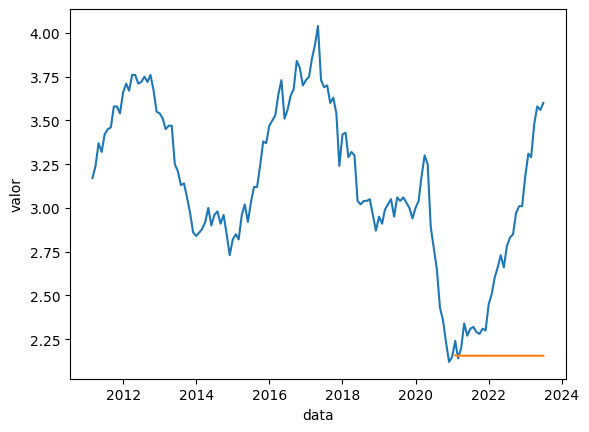

In [164]:
sns.lineplot(data = df, x= df.index, y = 'valor')
sns.lineplot(data = df, x = df.index, y = 'autoArimaPred')

Pelo gráfico já vemos que tem um desempenho ruim, vendo o RMSE:

In [165]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['valor'],  prediction_auto_arima))

0.7394144946270835

Com o modelo ARIMA(1,1,1) obtido usando a função `auto.arima`, obteve-se um valor de RMSE (erro quadrático médio) de aproximadamente 0.7394. Comparando com o resultado anterior, onde o RMSE era de cerca de 0.6002, podemos observar que o novo modelo ARIMA(1,1,1) possui um RMSE ligeiramente maior.

Isso significa que, em média, as previsões do novo modelo estão a uma distância um pouco maior dos valores reais de teste em comparação com o modelo anterior. Em termos de precisão de previsão, um RMSE mais baixo é geralmente preferível, pois indica que o modelo está fazendo previsões mais precisas.

Os modelos ARIMA apresentam desempenho insatisfatório e não conseguem capturar os efeitos da pandemia. Isso pode ocorrer porque os modelos ARIMA não são adequados para identificar padrões sazonais. Para incorporar a sazonalidade na série, utilizamos o modelo SARIMA. O processo é bastante semelhante, com os parâmetros permanecendo os mesmos, mas agora incluindo a componente sazonal mensal da série. Como a sazonalidade é mensal, utilizarei os parâmetros (1, 0, 1, 12). Iremos também utilizar a função AutoArima:

In [167]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [169]:
# Ajuste automaticamente o modelo SARIMA usando a função auto_arima
arima = auto_arima(df['valor'], seasonal=True, m=12)

# Exiba os melhores parâmetros encontrados
print("Melhores parâmetros sazonais encontrados:", arima.seasonal_order)

Melhores parâmetros sazonais encontrados: (1, 0, 1, 12)


Os parâmetros escolhidos pelo AutoArima são os mesmos definidos por mim, assim prosseguimos com a análise.

In [172]:
p, d, q = 1, 0, 1  #ordens não sazonais
P, D, Q, s = 1, 0, 1, 12  # ordens sazonais

model_sarima = SARIMAX(train['valor'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_sarima_fit = model_sarima.fit()
prediction_sarima = model_sarima_fit.predict(start=test.index[0], end=test.index[-1])


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [173]:
df['sarimaxPred'] =  prediction_sarima

In [174]:
df.tail()

,valor,ano,mes,media_movel,arimaPred,autoArimaPred,sarimaxPred
data,,,,,,,
2023-03-01,3.29,2023,3,2.7170,2.589765,2.155377,2.072946
2023-04-01,3.48,2023,4,2.7750,2.601212,2.155377,2.147995
2023-05-01,3.58,2023,5,2.8395,2.612354,2.155377,2.186368
2023-06-01,3.56,2023,6,2.9035,2.623202,2.155377,2.019360
2023-07-01,3.60,2023,7,2.9680,2.633762,2.155377,2.039282


<Axes: xlabel='data', ylabel='valor'>

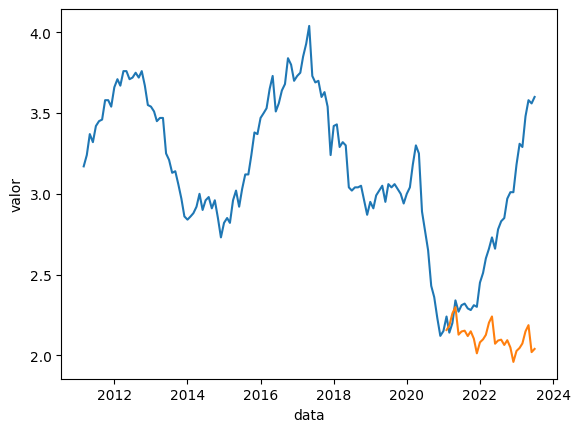

In [177]:
df.dropna()
sns.lineplot(data = df, x =df.index, y = 'valor')
sns.lineplot(data = df, x =df.index, y = 'sarimaxPred')

O modelo SARIMA consegue capturar a sazonalidade,mas ignora a tendência de subida no fim da série. Espera-se que ele tenha uma perfomance pior:

In [178]:
np.sqrt(mean_squared_error(test['valor'],  prediction_sarima))

0.7949006426809636

O modelo piorou. De acordo com nossos teste o modelo que teve a melhor performance foi o ARIMA(1,0,1): ou seja o ARMA (1,1).

# Forecasting: 12 meses

Com o modelo escolhido iremos seguir para a previsão para os próximos 12 meses.

In [180]:
df.tail()

,valor,ano,mes,media_movel,arimaPred,autoArimaPred,sarimaxPred
data,,,,,,,
2023-03-01,3.29,2023,3,2.7170,2.589765,2.155377,2.072946
2023-04-01,3.48,2023,4,2.7750,2.601212,2.155377,2.147995
2023-05-01,3.58,2023,5,2.8395,2.612354,2.155377,2.186368
2023-06-01,3.56,2023,6,2.9035,2.623202,2.155377,2.019360
2023-07-01,3.60,2023,7,2.9680,2.633762,2.155377,2.039282


In [186]:
futureDate = pd.DataFrame(pd.date_range(start='2023-07-01', end='2024-07-01', freq='MS'), columns = ['Data'])
futureDate.set_index('Data', inplace=True)

In [187]:
futureDate.head()

""
Data
2023-07-01
2023-08-01
2023-09-01
2023-10-01
2023-11-01


In [189]:
model_arima_fit.predict(start = futureDate.index[1], end=futureDate.index[-1])

2023-08-01    2.644042
2023-09-01    2.654049
2023-10-01    2.663792
2023-11-01    2.673276
2023-12-01    2.682508
2024-01-01    2.691496
2024-02-01    2.700246
2024-03-01    2.708764
2024-04-01    2.717056
2024-05-01    2.725128
2024-06-01    2.732986
2024-07-01    2.740636
Freq: MS, Name: predicted_mean, dtype: float64

<Axes: xlabel='data', ylabel='valor'>

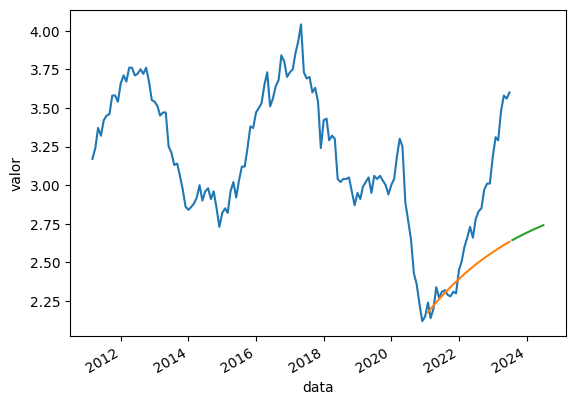

In [192]:
sns.lineplot(data = df, x= df.index, y = 'valor')
sns.lineplot(data = df, x= df.index, y = 'arimaPred')
model_arima_fit.predict(start = futureDate.index[1], end=futureDate.index[-1]).plot()

In [195]:
print(model_arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                  119
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 104.979
Date:                Wed, 06 Sep 2023   AIC                           -201.957
Time:                        19:47:10   BIC                           -190.841
Sample:                    03-01-2011   HQIC                          -197.443
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0216      0.504      5.998      0.000       2.034       4.009
ar.L1          0.9735      0.025     39.246      0.000       0.925       1.022
ma.L1          0.1461      0.106      1.380      0.1

# Série com primeira diferença

Como uma última tentativa, iremos fazer a modeloagem retirando a tendência da série:

In [228]:
first_diff = df.diff().dropna()



In [229]:
first_diff = first_diff[['valor']].copy()

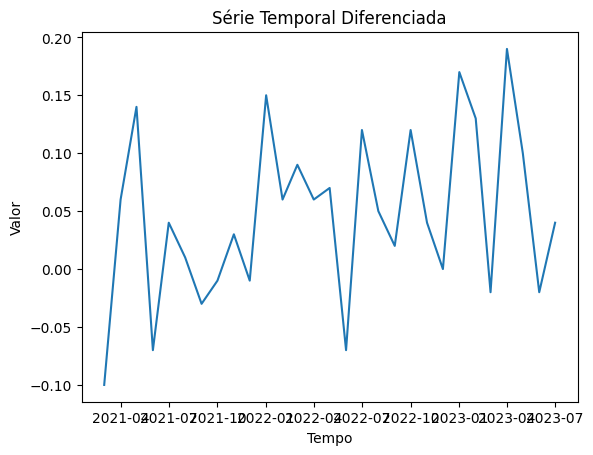

In [230]:
# Plote a série diferenciada
plt.plot(first_diff['valor'])
plt.title('Série Temporal Diferenciada')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.show()

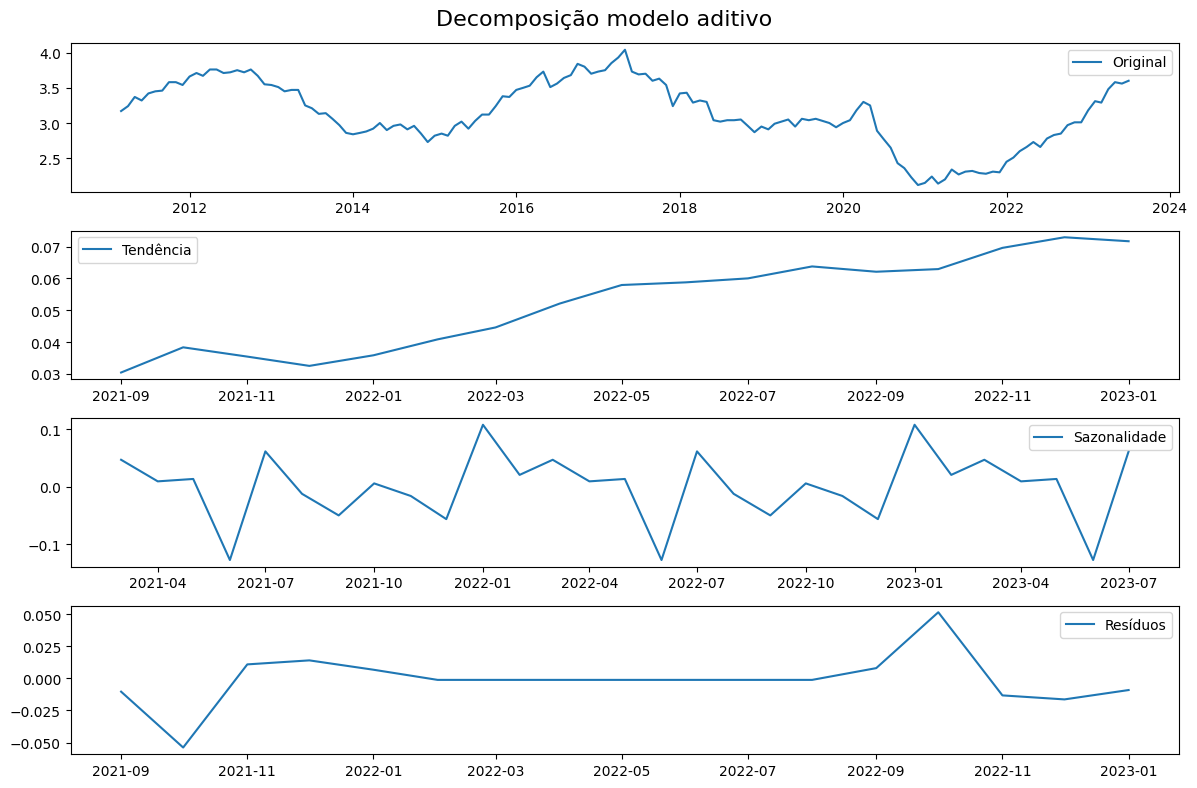

In [231]:
decomposition_diff = sm.tsa.seasonal_decompose(first_diff['valor'], model='additive')

tendencia = decomposition_diff.trend
sazonalidade = decomposition_diff.seasonal
residuo = decomposition_diff.resid

plt.figure(figsize=(12, 8))
plt.suptitle('Decomposição modelo aditivo', fontsize=16)
plt.subplot(411)
plt.plot(df['valor'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Tendência')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(sazonalidade, label='Sazonalidade')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuo, label='Resíduos')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

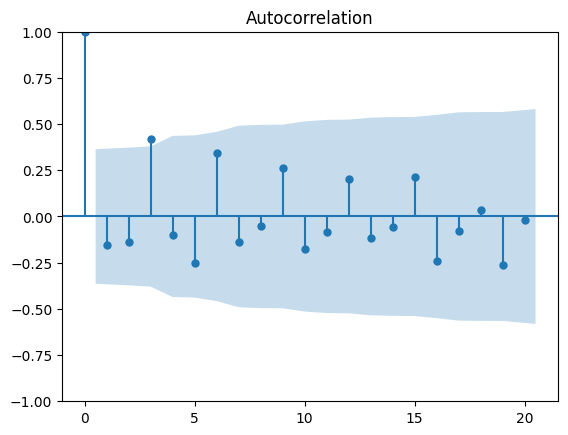

In [232]:
plot_acf(first_diff['valor'], lags=20);

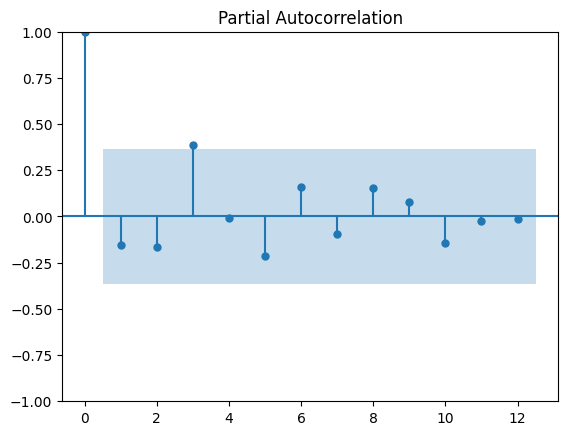

In [233]:
plot_pacf(first_diff['valor'], lags=12);

In [239]:
train_diff = first_diff[:round(len(first_diff)*80/100)]
test_diff = first_diff[round(len(first_diff)*80/100):]

In [240]:
model_arima_diff = ARIMA(train_diff['valor'], order=(1, 1, 1))
model_arima_fit_diff = model_arima_diff.fit()
prediction_arima_diff = model_arima_fit_diff.predict(start=test_diff.index[0], end=test_diff.index[-1])

In [242]:
first_diff['arimaPred'] = prediction_arima_diff


<Axes: xlabel='data', ylabel='valor'>

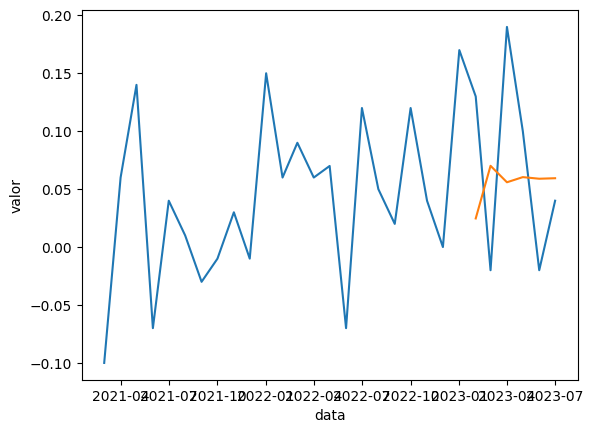

In [243]:
sns.lineplot(data = first_diff, x= first_diff.index, y = 'valor')
sns.lineplot(data = first_diff, x= first_diff.index, y = 'arimaPred')

In [244]:
np.sqrt(mean_squared_error(test_diff['valor'],  prediction_arima_diff))

0.0869618460637619

In [245]:
p, d, q = 1, 0, 1  #ordens não sazonais
P, D, Q, s = 1, 0, 1, 12  # ordens sazonais

model_sarima_diff = SARIMAX(train_diff['valor'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_sarima_fit_diff = model_sarima_diff.fit()
prediction_sarima_diff = model_sarima_fit_diff.predict(start=test_diff.index[0], end=test_diff.index[-1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [246]:
first_diff['sarimaxPred'] =  prediction_sarima_diff

<Axes: xlabel='data', ylabel='valor'>

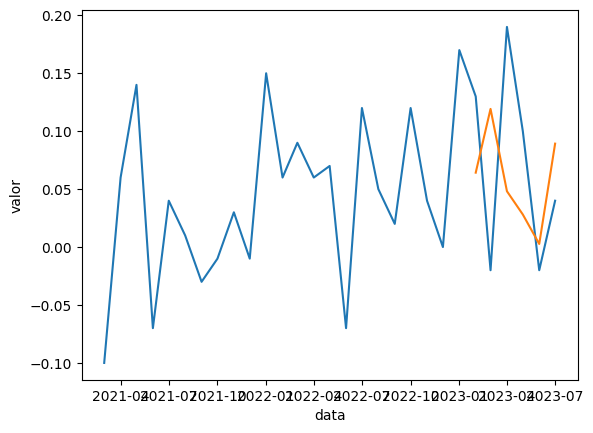

In [247]:
first_diff.dropna()
sns.lineplot(data = first_diff, x =first_diff.index, y = 'valor')
sns.lineplot(data = first_diff, x =first_diff.index, y = 'sarimaxPred')

In [248]:
np.sqrt(mean_squared_error(test_diff['valor'],  prediction_sarima_diff))

0.09304177533310283

um RMSE de 0.0869618460637619 é melhor do que um RMSE de 0.09304177533310283, pois é menor, o que sugere que o modelo correspondente às previsões com esse RMSE tem um desempenho superior em relação aos dados reais em comparação com o modelo correspondente ao RMSE mais alto. Mas pela análise gráfica o SARIMA parece se comportar melhor.

In [251]:
print(model_arima_fit_diff.summary())


                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                   23
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  26.093
Date:                Wed, 06 Sep 2023   AIC                            -46.186
Time:                        20:24:39   BIC                            -42.913
Sample:                    03-01-2021   HQIC                           -45.415
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3127      0.282     -1.108      0.268      -0.866       0.241
ma.L1         -0.8389      0.218     -3.847      0.000      -1.266      -0.411
sigma2         0.0050      0.002      2.536      0.0

In [252]:
print(model_sarima_fit_diff.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              valor   No. Observations:                   23
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                  28.601
Date:                            Wed, 06 Sep 2023   AIC                            -47.203
Time:                                    20:24:52   BIC                            -41.525
Sample:                                03-01-2021   HQIC                           -45.775
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9536      0.584      1.632      0.103      -0.192       2.099
ma.L1         -0.8476      1.014   

##  Forecasting: ARIMA



In [300]:
forecast_steps = 18 # 1 ano, de agosto de 2023 a julho de 2024

forecast_diff = model_arima_fit_diff.forecast(steps=forecast_steps)

In [301]:
forecast_diff

2023-02-01    0.024693
2023-03-01    0.070127
2023-04-01    0.055921
2023-05-01    0.060363
2023-06-01    0.058974
2023-07-01    0.059408
2023-08-01    0.059273
2023-09-01    0.059315
2023-10-01    0.059302
2023-11-01    0.059306
2023-12-01    0.059305
2024-01-01    0.059305
2024-02-01    0.059305
2024-03-01    0.059305
2024-04-01    0.059305
2024-05-01    0.059305
2024-06-01    0.059305
2024-07-01    0.059305
Freq: MS, Name: predicted_mean, dtype: float64

In [302]:
# Recupere os últimos valores reais conhecidos
last_values = df['valor'][-18:].values  # Últimos 12 valores conhecidos

# Calcula as previsões originais somando as previsões da primeira diferença aos últimos valores reais
forecast_original = forecast_diff + last_values[::-1]

In [303]:
forecast_original

2023-02-01    3.624693
2023-03-01    3.630127
2023-04-01    3.635921
2023-05-01    3.540363
2023-06-01    3.348974
2023-07-01    3.369408
2023-08-01    3.239273
2023-09-01    3.069315
2023-10-01    3.069302
2023-11-01    3.029306
2023-12-01    2.909305
2024-01-01    2.889305
2024-02-01    2.839305
2024-03-01    2.719305
2024-04-01    2.789305
2024-05-01    2.719305
2024-06-01    2.659305
2024-07-01    2.569305
Freq: MS, Name: predicted_mean, dtype: float64

In [314]:
forecast_df = pd.DataFrame({'Forecast': forecast_original})
forecast_df

,Forecast
2023-02-01,3.624693
2023-03-01,3.630127
2023-04-01,3.635921
2023-05-01,3.540363
2023-06-01,3.348974
2023-07-01,3.369408
2023-08-01,3.239273
2023-09-01,3.069315
2023-10-01,3.069302
2023-11-01,3.029306


In [315]:
forecast_df = forecast_df.iloc[3:]
forecast_df

,Forecast
2023-05-01,3.540363
2023-06-01,3.348974
2023-07-01,3.369408
2023-08-01,3.239273
2023-09-01,3.069315
2023-10-01,3.069302
2023-11-01,3.029306
2023-12-01,2.909305
2024-01-01,2.889305
2024-02-01,2.839305


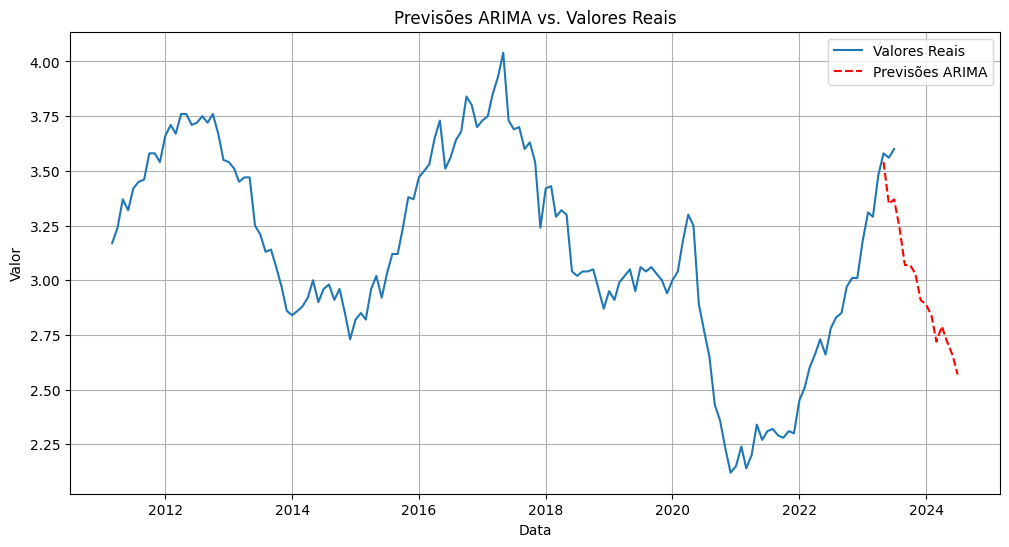

In [316]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['valor'], label='Valores Reais')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Previsões ARIMA', color='red', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Previsões ARIMA vs. Valores Reais')
plt.legend()
plt.grid(True)
plt.show()

##  Forecasting: SARIMA


In [325]:
forecast_steps = 18 # 1 ano, de agosto de 2023 a julho de 2024

forecast_diff_sarima = model_sarima_fit_diff.forecast(steps=forecast_steps)

In [319]:
forecast_diff_sarima

2023-02-01    0.064204
2023-03-01    0.119238
2023-04-01    0.048173
2023-05-01    0.028107
2023-06-01    0.002673
2023-07-01    0.089263
2023-08-01    0.052427
2023-09-01    0.044560
2023-10-01    0.101631
2023-11-01    0.036485
2023-12-01    0.022319
2024-01-01    0.080591
Freq: MS, Name: predicted_mean, dtype: float64

In [326]:
# Recupere os últimos valores reais conhecidos
last_values = df['valor'][-18:].values  # Últimos 12 valores conhecidos

# Calcula as previsões originais somando as previsões da primeira diferença aos últimos valores reais
forecast_original_sarima = forecast_diff_sarima + last_values[::-1]

In [327]:
forecast_df_sarima = pd.DataFrame({'Forecast': forecast_original_sarima})
forecast_df_sarima

,Forecast
2023-02-01,3.664204
2023-03-01,3.679238
2023-04-01,3.628173
2023-05-01,3.508107
2023-06-01,3.292673
2023-07-01,3.399263
2023-08-01,3.232427
2023-09-01,3.054560
2023-10-01,3.111631
2023-11-01,3.006485


In [329]:
forecast_df = forecast_df.iloc[3:]
forecast_df

,Forecast
2023-08-01,3.239273
2023-09-01,3.069315
2023-10-01,3.069302
2023-11-01,3.029306
2023-12-01,2.909305
2024-01-01,2.889305
2024-02-01,2.839305
2024-03-01,2.719305
2024-04-01,2.789305
2024-05-01,2.719305


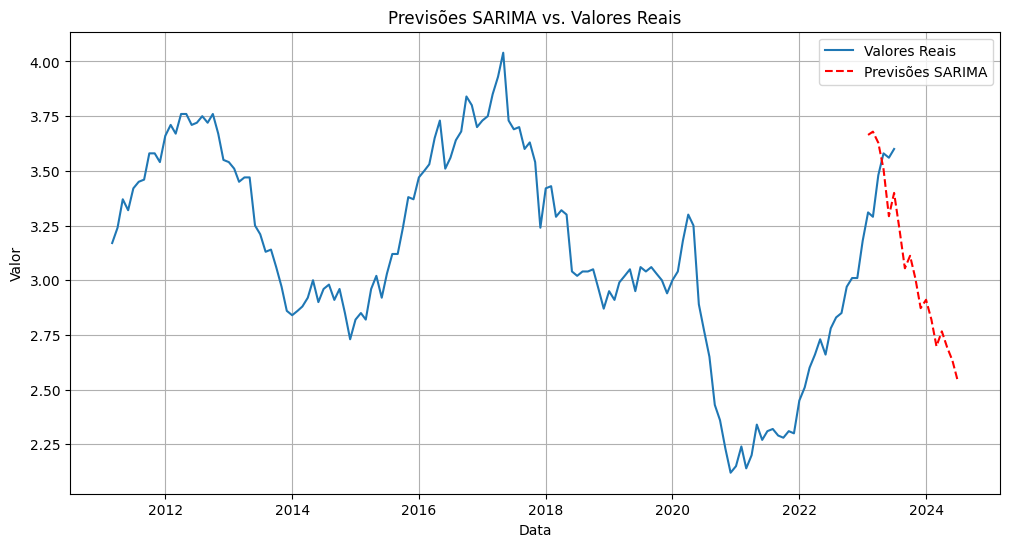

In [330]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['valor'], label='Valores Reais')
plt.plot(forecast_df_sarima.index, forecast_df_sarima['Forecast'], label='Previsões SARIMA', color='red', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Previsões SARIMA vs. Valores Reais')
plt.legend()
plt.grid(True)
plt.show()